In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [1]:
from typing import TypedDict
from typing_extensions import Annotated
from langgraph.graph.message import add_messages

In [3]:
class State(TypedDict):
    messages : Annotated[list,add_messages]

In [5]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

In [6]:
llm = ChatGroq(model="openai/gpt-oss-20b", api_key=os.getenv("groq_api_key"))

In [7]:
llm.invoke("hello").content

'Hello! 👋 How can I help you today?'

In [9]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a customer care bot, tell me whether the given problem is based on Billing issue, Technical issue or Feedback."),
        ("user", "issue: {issue}")
    ]
)

chain = prompt|llm

chain.invoke({"issue":"I was charged extra for items"}).content

'**Billing issue**'

In [10]:
def interface_llm(state: State):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a customer care bot, tell me whether the given problem is based on Billing issue, Technical issue or Feedback."),
            ("user", "issue: {issue}")
        ]
    )
    chain = prompt|llm
    user_msg = state["messages"][-1].content
    response = chain.invoke({"issue": user_msg})
    return {"messages" : state["messages"] + [response]}


In [11]:
def node_router(state: State):
    classification = state['messages'][-1].content.lower().strip()
    
    if "billing" in classification:
        return "billingnode"
    elif "technical" in classification:
        return "technicalnode"
    elif "feedback" in classification:
        return "feedbacknode"
    else:
        return "feedbacknode"

In [12]:
def billing_llm(state: State):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a billing support assistant. Help the user with questions about payments, invoices, subscriptions, refunds, and account charges. Provide information clearly and professionally. If sensitive data or verification is needed, politely instruct the user on what to do without asking for confidential information directly. Keep a polite and reassuring tone."),
            ("user", "issue: {issue}")
        ]
    )
    chain = prompt|llm
    user_msg = state["messages"][-2].content
    response = chain.invoke({"issue": user_msg})
    return {"messages" : state["messages"] + [response]}

In [13]:
def technical_llm(state: State):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a technical support assistant. Understand the user’s issue, ask for missing information only if required, and provide clear, step-by-step troubleshooting instructions. Keep explanations simple, avoid jargon when possible, and ensure accuracy. Be calm, patient, and solution-oriented."),
            ("user", "issue: {issue}")
        ]
    )
    chain = prompt|llm
    user_msg = state["messages"][-2].content
    response = chain.invoke({"issue": user_msg})
    return {"messages" : state["messages"] + [response]}

In [14]:
def feedback_llm(state: State):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a friendly feedback assistant. Thank the user for sharing their feedback, acknowledge their concern clearly, and assure them that their input helps improve the service. Keep the tone positive, concise, and supportive."),
            ("user", "issue: {issue}")
        ]
    )
    chain = prompt|llm
    user_msg = state["messages"][-2].content
    response = chain.invoke({"issue": user_msg})
    return {"messages" : state["messages"] + [response]}

In [15]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)
#adding nodes
graph_builder.add_node("interface", interface_llm)
graph_builder.add_node("billing", billing_llm)
graph_builder.add_node("technical", technical_llm)
graph_builder.add_node("feedback", feedback_llm)

#adding edges
graph_builder.add_edge(START, "interface")
graph_builder.add_conditional_edges(
    "interface",
    node_router,
    {
        "billingnode": "billing",
        "technicalnode": "technical",
        "feedbacknode": "feedback"
    }
)
graph_builder.add_edge("billing", END)
graph_builder.add_edge("technical", END)
graph_builder.add_edge("feedback", END)

#compiling graph
graph = graph_builder.compile()

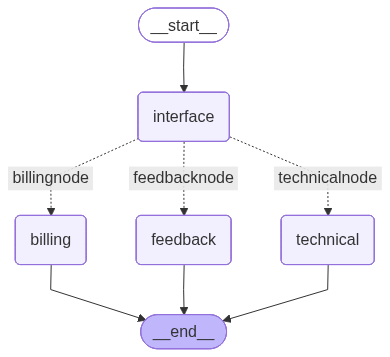

In [16]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
response = graph.invoke({"messages":"i was charged double for my order"})
print(response["messages"][-1].content)

I’m sorry to hear that you were charged twice for your order. Let’s get this sorted out quickly.

**Here’s what we’ll do:**

1. **Confirm the Order**  
   Please provide the order number (or the email address you used for the purchase) and the date of the transaction.  
   *If you’re uncomfortable sharing the full order number, just the first few digits and the last two are fine.*

2. **Review the Charges**  
   Once I have that information, I’ll pull up the transaction details and confirm the duplicate charge.

3. **Refund the Duplicate Amount**  
   If a duplicate charge is found, we’ll issue a refund to the original payment method.  
   *Refunds typically appear on your statement within 3–5 business days, depending on your bank.*

4. **Prevent Future Occurrences**  
   I’ll also check for any system issues that may have caused the double charge and make sure your account is safe.

**What you can do in the meantime:**

- Double‑check your bank or credit‑card statement to see if the d